| 주차 | 일정                               | 페이지                                  |
|-----:|-----------------------------------|----------------------------------------|
|    1 | 1장-헬로 파이썬                     | 0p ~ 45p                               |
|    2 | 2장-퍼셉트론                        | 46p ~ 62p                              |
|    3 | 3장-신경망                          | 63p ~ 105p                             |
|    4 | 4장-신경망 학습                     | 106p ~ 146p                            |
|    5 | 5장-오차역전파법                    | 147p ~ 187p (+ Appendix A, 292p ~ 299p) |
|    6 | 중간고사(전)                        |                                        |
|    7 | 중간고사                           |                                        |
|    8 | 6장-학습 관련 기술들               | 188p ~ 226p                            |
|    9 | 7장-합성곱 신경망(CNN)             | 227p ~ 259p                            |
|   10 | 딥러닝                             | 261p ~ 308p                            |
|   11 | 1장-신경망 복습                    | 0p ~ 74p (+ Appendix A, 389p ~ 394p)  |
|   12 | 2장-자연어와 단어의 분산 표현      | 78p ~ 113p (+ Appendix B, 395p ~ 399p) |
|   13 | 기말고사(전)                       |                                        |
|   14 | 기말고사                          |                                        |
|   15 | 3장-word2vec                       | 114p ~ 147p                            |
|   16 | 4장-word2vec 속도 개선             | 148p ~ 189p                            |
|   17 | 5장-순환신경망(RNN)                | 190p ~ 235p                            |
|   18 | 6장-게이트가 추가된 RNN            | 263p ~ 286p (+ Appendix C, 401p ~ 402p)|
|   19 | 7장-RNN을 사용한 문장 생성         | 287p ~ 333p                            |
|   20 | 8장-어텐션                         | 334p ~ 387p                            |

# 15주차

word2vec

_114~147p_

---

SVD 같은 통계기반 기법을 사용하면 문제가 말뭉치의 수가 엄청 많음으로 (영어같은 경우 100만개) 이러한 행렬을 SVD등에 적용하기는 현실적으로 어려움.

통계기반은 큰 행렬에 대하여 한번에 계산하지만 추론기반 기법은 미니배치(minibatch)기준으로 여러번 작은 샘플을 학습하여 training을 진행한다.

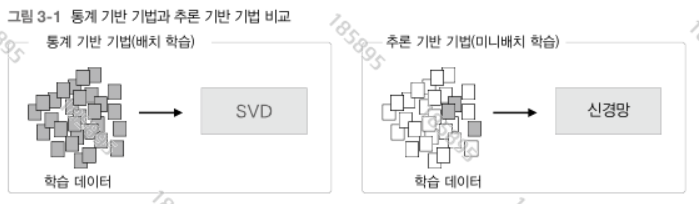

제일 큰 장점이 부분적 batch단위로 학습이 되므로 자료량이 엄청 커도 학습이 된다는 점!

가장 대표적인 통계기반 기법이 바로 word2vec이다.

이름에서도 나오듯이 "추론"기반이므로 모델은 주변 단어들을 기준으로 채워야할 부분에 어떤 단어가 들어갈지 "추론"하는 것이다.

이를 미니배칭 훈련과정을 통해 배우는 것이고...

모델은 맥락정보를 통해 결론적으로 쓸 수 있는 각 단어들에 대한 출현 확률을 계산하는 것이다.

---

신경망은 고정된 길이를 보통 받을 수 있으니 단어들을 고정된 형태로 표현해야한다. 그래서 one-hot vector로 단어들을 표현한다.

해당 단어에 해당하는 부분만 1로 표현하고 나머지는 0으로 표현하는 방식

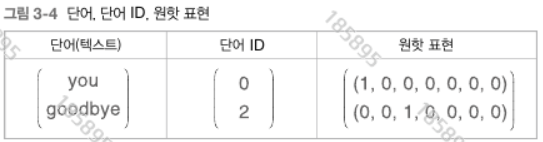

이렇게 되면 신경망에 그냥 그대로 집어넣어도 문제 없음. 완전연결계층/dense/affine을 통하여 다음다음 레이어로 넘어감...

코드로 작은 예시를 보면 다음과 같음: (bias는 없음)

In [1]:
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[-0.74727778 -1.66789355 -0.29470271]


그런데 생각해보면 one-hot encoding때문에 `W[0][:]`만 계산하는거처럼 보이는데, 나중에 개선한 방식이 나온다고 한다...

---

word2vec을 이제 구현을 해본다면, word2vec의 아키텍처인 CBOW(Continuous Bag of Words) 모델이 있다.

앞서 "추론"한다고 말했듯이, 이 모델또한 주변맥락을 통해 타겟을 주측하는 용도이다. 모델은 주변 맥락은 인풋으로 받고, 아웃풋이 그 "빈공간/타겟"에 해당하는 가장 그럴듯한 단어들이다. 

만약 주변 단어 (왼쪽, 오른쪽) 2개를 받는다면 모델은 다음과 같은 모양이다.

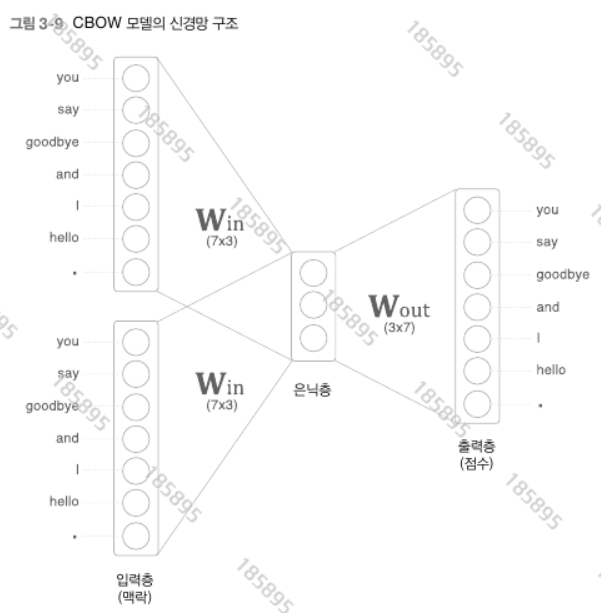

2개의 입력에 대하여 은닉층에서 보통 평균이 되도록 두 입력을 처리한다. `value / no. inp.`식으로 말이죠, 은닉층을 거치면 다시 1단어를 상징하는 one-hot인토딩으로 나오는데, 여기서 나온 출력값들이 곧 각 단어들이 나올 확률을 상징한다. 근데 이 벡터가 다른 단어들과의 연관성도 어느정도 표현하고 있으므로, 단어의 의미도 포함하고 있다고 볼 수 있다.

계층 관점에서 보다면, 다음과 같음. 중간에 0.5곱하는 이유는 평균내기용 나누기 2임.

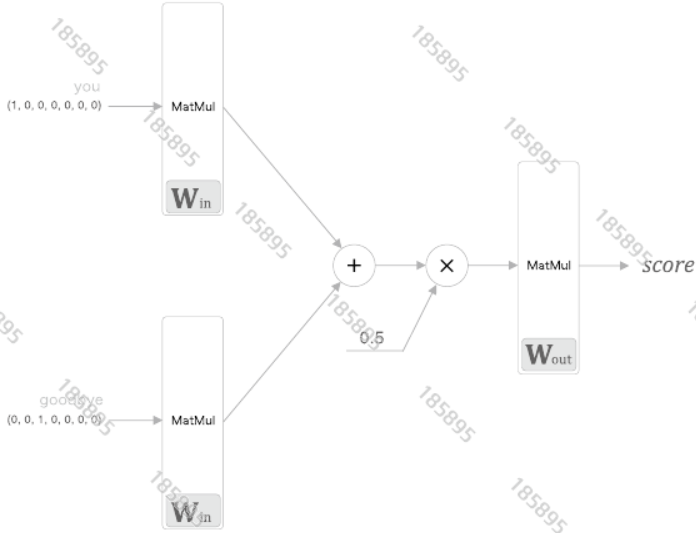

구현하면 다음과 같다.

In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
h = out_layer.forward(h)

print(h)

[ 1.6191853   3.39923171 -1.59607824 -2.23130098  1.87687763 -1.323077
 -3.39971108]


`h[1]`인 say가 가장 큰값을 가지고 있음을 볼 수 있다.

나중에는 softmax함수를 써서 답을 도출함, 그림으로 보면 다음과 같음.

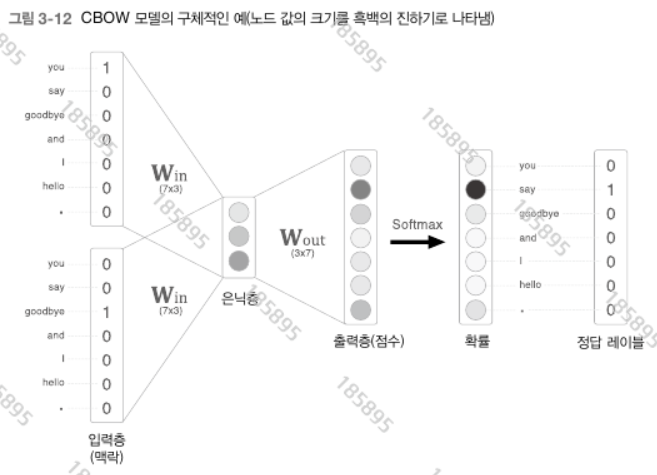

---

다른 모델들과 같이 CBOW또한 모델안의 가중치들을 조정해서 성능을 개선해나간다. 

그래서 전에 다뤘던 calssification모델처럼 이 모델도 똑같이 설계를 한다. softmax다음, 오류는 cross entorpy error를 사용하고 원래 답이랑 대조해서 역전파를 진행한다.

그런데 softmax함수는 CEE랑 Softmax with Loss함수로 합할 수 있으므로 최종 구조는 다음과 같다.

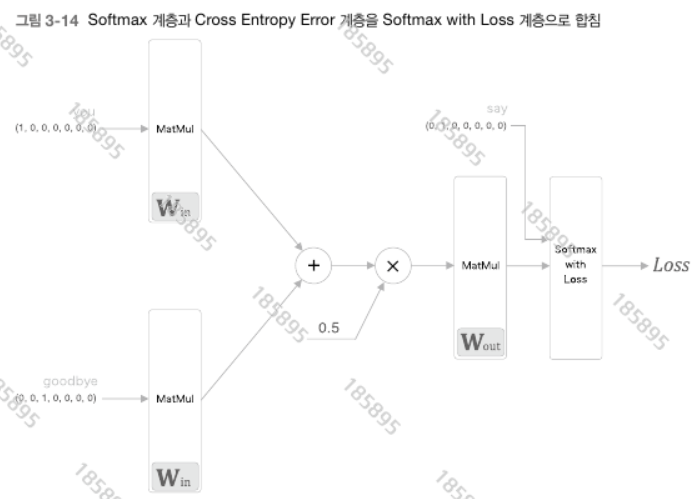

CBOW 모델은 예시에서 본거처럼 빈칸채워넣기/단어예측모델이 본 용도가 아니라 벡터화/embedding 모델이므로 training때만 사실상 output을 사용하게 된다. - loss 계산할때 본 단어로 복구해야하므로

그래서 결론적으로 $W_{in}$만 사용하게 되는 이유이다. 이런 벡터화/embeddding하는 분산표현이 대중적인 단어의 의미적 표현이 된다.

이제 진짜 문장에 대하여 제대로 구현을 한다면:

In [ ]:
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


앞서 이야기했듯이 traning위해서는 원 형상에 대한 주변단어 2개 맥락과 그 사이에 들어가는 타깃이 있다. 이걸 행렬로 본다면 다음과 같음.

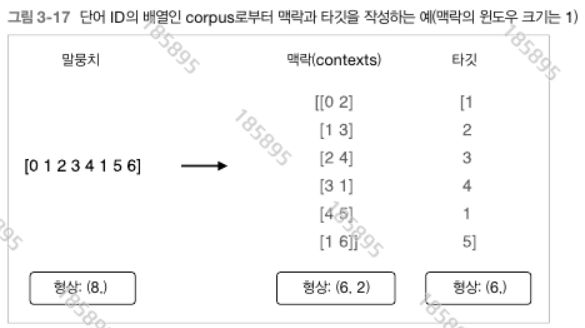

행렬의 형태가 context window를 밀어가며 그 사이에 들어가있는 타겟도 밀려가는 모양, 이 context와 target행렬 만들기 위한 함수는 다음과 같음:

```python
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)
```

In [7]:
from common.util import create_contexts_target, convert_one_hot

contexts, target = create_contexts_target(corpus, window_size=1)

contexts, target

(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5],
        [1, 6]]),
 array([1, 2, 3, 4, 1, 5]))

앞에서 말했던 모델은 one-hot 인코딩으로 input을 받는다는 사실~

ID로 인코딩이 되어있으므로 onr-hot으로 변환해준다.

In [9]:
contexts_one_hot = convert_one_hot(contexts, vocab_size=len(word_to_id))
target_one_hot = convert_one_hot(target, vocab_size=len(word_to_id))

contexts_one_hot, target_one_hot

(array([[[1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]]], dtype=int32),
 array([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]], dtype=int32))

In [14]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        # self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5

        # 0.5곱하고 그대로 전 레이어 2개로 넘기기기
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

학습코드 부분

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

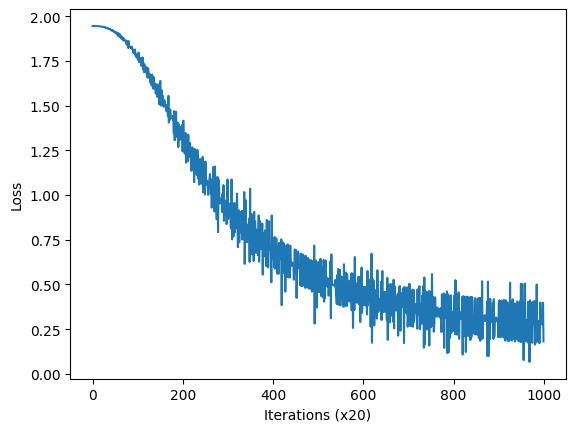

In [15]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

결과에서의 벡터 임베딩을 확인해보면 다음과 같다:

In [16]:
word_vecs = model.word_vecs
[print(w, word_vecs[wi]) for wi, w in id_to_word.items()]
print()

you [ 0.9816923   1.4409854  -0.9127744  -0.98995215 -1.5572934 ]
say [-0.2211989  -0.68478185  0.5367395   1.3727417  -1.2458309 ]
goodbye [ 0.9746291  -0.09828785 -1.1554377  -1.222414    0.69253653]
and [ 1.2958788 -1.4733536 -1.2329761  1.2523235 -0.8872635]
i [ 0.9951089  -0.10860845 -1.1424494  -1.2128165   0.68769604]
hello [ 0.9995763  1.431321  -0.9354914 -0.961484  -1.5651718]
. [-1.2587965  1.3992158  1.2125714  1.064495  -1.2067877]



---

CBOW와 모델의 확률을 본다면, 타겟 단어를 $\omega_t$라고 하고 주변 단어를 각각 $\omega_{t-1}, \omega_{t+1}$라고 한다면, 타겟이 맥락에 맞게 들어갈 확률 다음과 같이 표현할 수 있다.
$$
P(\omega_t | \omega_{t-1}, \omega_{t+1})
$$
다시말하자면 맥락들이 있는 상황에서 해당 타겟이 발생할/있을 확률이다.

그러므로 위 식에 에 음의 로그만 씌워주면 손실함수로 만들 수 있다.
$$
L = -\log(P(\omega_t | \omega_{t-1}, \omega_{t+1})) \text{ (한 단어에 대해서)}
$$
$$
L = -\frac{1}{T}\sum_{t=1}^{T}\log(P(\omega_t | \omega_{t-1}, \omega_{t+1})) \text{ (문장에에 대해서)}
$$

음의로그는 이런 모양이므로 뭐 그렇다고 합니다...

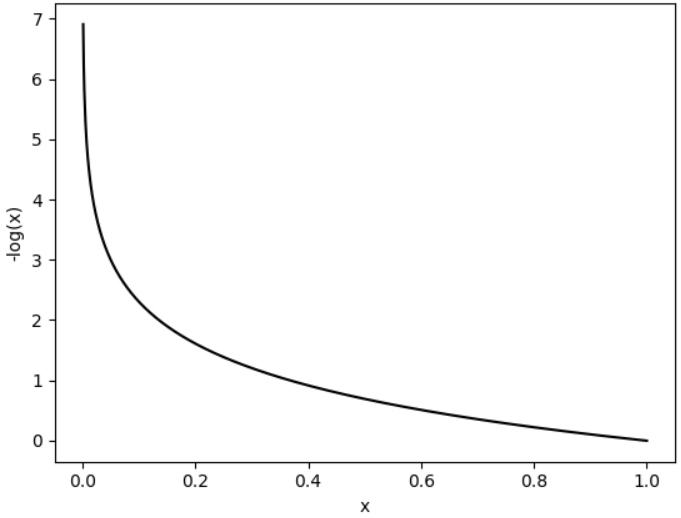

skip-gram은 skip n-gram(unigram, bigram, trigram...)을 줄인말으로, n만큼 건너뛴 단어를 예측한다는 말임.

주변단어 context를 써서 중간에 target을 구하는게 아니라 skip-gram은 가운데 target단어로 n개 덩어리 기준준 주변 단어를 예측하는 것이다. 앞서본 예시에서도 그렇고 보통은 옆 왼쪽, 오른쪽 단어를 예측한다.

예시를 본다면:
>The cat sat

cat 기준 n-gram skip 진행하면
`The cat`, `cat sat` 2개인 2-gram으로 구성이 된다. 의미전달은 `The` <- `cat` -> `sat` 형태로 진행됨

3-gram으로 하면 `The cat sat` 통으로.

이 구성을 보면 두개를 써서 cat의미구성하는게 아니라 왼쪽꺼 따로 오른쪽꺼 따로 사용해서 의미를 구성하므로 "조건부 독립"관계라고 볼 수 있다. 그래서 여기에 대한 손실함수 만들려면 그냥 반으로 쪼개서 곱하면 된다. 과정을 본다면:


$$
L = -\log(P(\omega_{t-1}, \omega_{t+1} | \omega_t)) 
= -\log( P(\omega_{t-1} | \omega_t)P(\omega_{t+1} | \omega_t) ) 
= -\log( P(\omega_{t-1} | \omega_t))+\log(P(\omega_{t+1} | \omega_t) )
$$

$$
L = -\frac{1}{T}\sum_{t=1}^{T}\log(P(\omega_{t-1} | \omega_t)) + \log(P(\omega_{t+1} | \omega_t)) \text{ (문장에 대해서)}
$$

직관적으로 봤을 때 주변 여러단어들의 의미로 하나를 구성하는거보다 단어별로 주변 단어들에게 의미를 부여하며 쌓아나가는게 더 좋다고 볼 수 있음.

**skip-gram 특징**
- CBOW비해 training시간이 더 걸림
- embedding 정확히 만드는 편편
- 희귀한 단어라도 embedding잘 만듦
- 문장의 크기나 양 상관없이 일관된 성능